In [218]:
# import sys
# !{sys.executable} -m pip install --upgrade tensorflow 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
import janitor
import tabulate
from tqdm import tqdm
from IPython.display import display, HTML
# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

RS = range(0,25,1)


In [2]:
print(tf.__version__)


2.9.1


In [219]:
Glam = pd.read_csv('Glam.csv')
Glam = Glam[[
#         'LAT',
#         'LON',
    'CenLon',
    'CenLat',
    'Area',
    'thickness',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Aspect',
    'Lmax'
]]


Glam_phys = Glam[[
#         'LAT',
#         'LON',
#     'CenLon',
#     'CenLat',
    'Area',
    'thickness',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Aspect',
    'Lmax'
]]


deviations_Glam = pd.read_csv('zults/deviations_Glam.csv')
deviations_Glam = deviations_Glam[[
    'layer architecture',
    'model parameters',
    'learning rate',
    'validation split',
    'epochs',
    'test mae avg',
    'train mae avg',
    'test mae std dev',
    'train mae std dev',
    'test predicted thickness std dev',
    'train predicted thickness std dev'
]]


deviations_Glam_phys = pd.read_csv('zults/deviations_Glam_phys.csv')
deviations_Glam_phys = deviations_Glam_phys[[
#         'LAT',
#         'LON',
    'layer architecture',
    'model parameters',
    'learning rate',
    'validation split',
    'epochs',
    'test mae avg',
    'train mae avg',
    'test mae std dev',
    'train mae std dev',
    'test predicted thickness std dev',
    'train predicted thickness std dev'
]]


deviations_glacier = pd.read_csv('zults/deviations_glacier.csv')
deviations_glacier = deviations_glacier[[
#         'LAT',
#         'LON',
    'layer architecture',
    'model parameters',
    'learning rate',
    'validation split',
    'epochs',
    'test mae avg',
    'train mae avg',
    'test mae std dev',
    'train mae std dev',
    'test predicted thickness std dev',
    'train predicted thickness std dev'
]]


RGI_prethicked_Glam = pd.read_csv('zults/RGI_prethicked_Glam.csv')
RGI_prethicked_Glam = RGI_prethicked_Glam[[
#         'LAT',
#         'LON',
    'CenLon',
    'CenLat',
    'Area',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Aspect',
    'Lmax',
    'avg predicted thickness',
    'predicted thickness std dev',
#     'variance'
]]

RGI_prethicked_Glam_phys = pd.read_csv('zults/RGI_prethicked_Glam_phys.csv')
RGI_prethicked_Glam_phys = RGI_prethicked_Glam_phys[[
#         'LAT',
#         'LON',
#     'CenLon',
#     'CenLat',
    'Area',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Aspect',
    'Lmax',
    'avg predicted thickness',
    'predicted thickness std dev',
#     'variance'
]]



# Glam = pd.read_csv('Glam.csv')
# Glam = pd.read_csv('Glam.csv')
# Glam = pd.read_csv('Glam.csv')

In [229]:
deviations_Glam

,layer architecture,model parameters,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev
0,24-12-6,644.0,0.010,0.2,300,10.680168,10.624562,0.861260,0.760157,1.358634,1.324749
1,32-16-8,1012.0,0.010,0.2,300,11.244883,9.754352,0.778489,0.920720,1.088460,1.008510
2,16-8,324.0,0.100,0.2,300,11.489019,10.791455,1.172964,0.954984,2.385223,2.000087
3,16-8,324.0,0.010,0.2,300,12.089952,12.199348,0.548000,0.668366,0.947284,0.839435
4,12-6,224.0,0.010,0.2,300,12.171543,12.968094,0.771822,0.578234,1.074586,0.933290
5,24-12-6,644.0,0.100,0.2,300,12.310521,11.229546,1.278244,1.268548,2.812962,2.601822
6,10-5,180.0,0.010,0.2,300,12.389454,13.060606,0.648540,0.557949,0.761223,0.740823
7,12-6,224.0,0.100,0.2,300,12.482715,11.404785,0.928767,1.318811,2.433475,2.174532
8,12-8,252.0,0.100,0.2,300,12.486080,11.362632,1.071563,0.873662,2.440977,1.960460
9,32-16-8,1012.0,0.001,0.2,300,12.518682,13.118342,0.384845,0.400125,0.540445,0.486124


loading and evaluating models...


100%|██████████| 125/125 [00:15<00:00,  7.82it/s]
/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


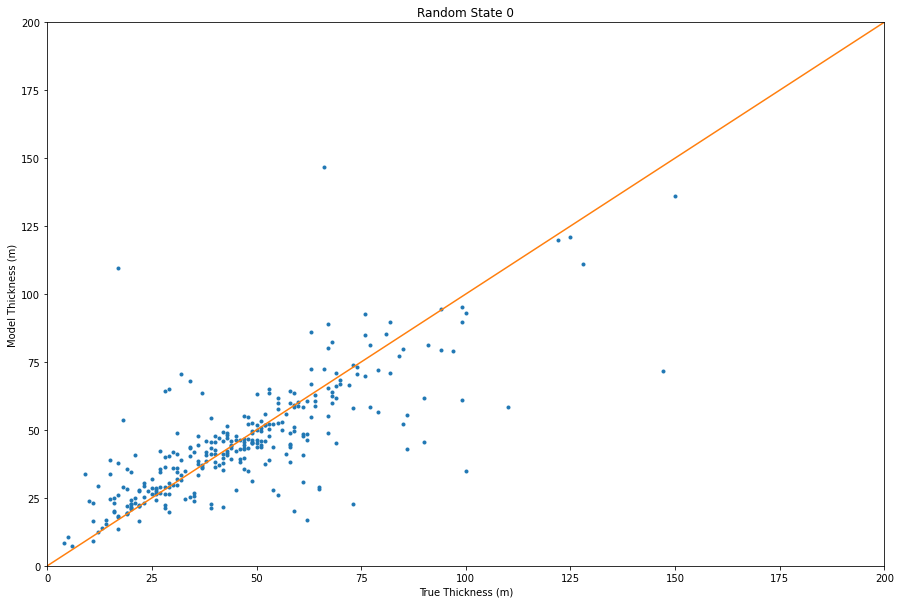

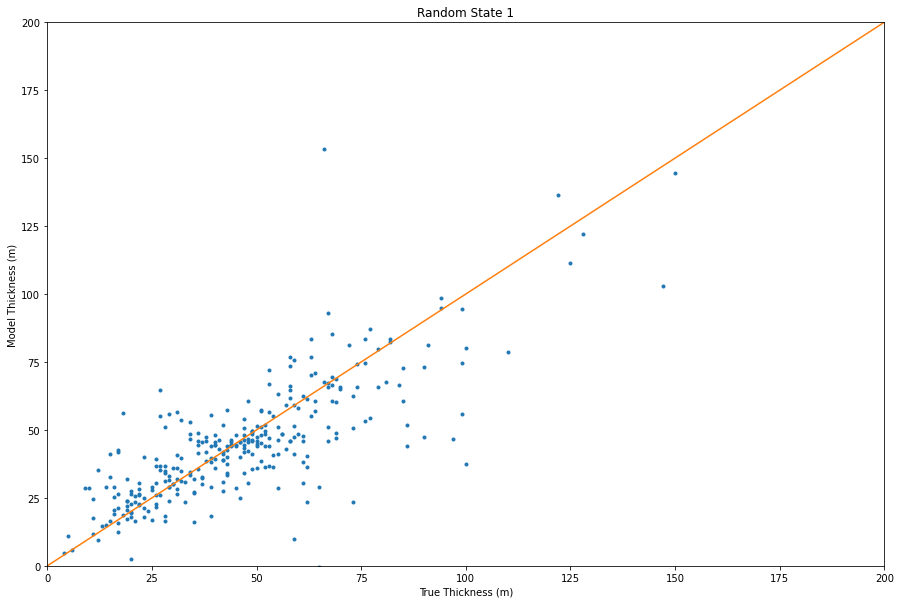

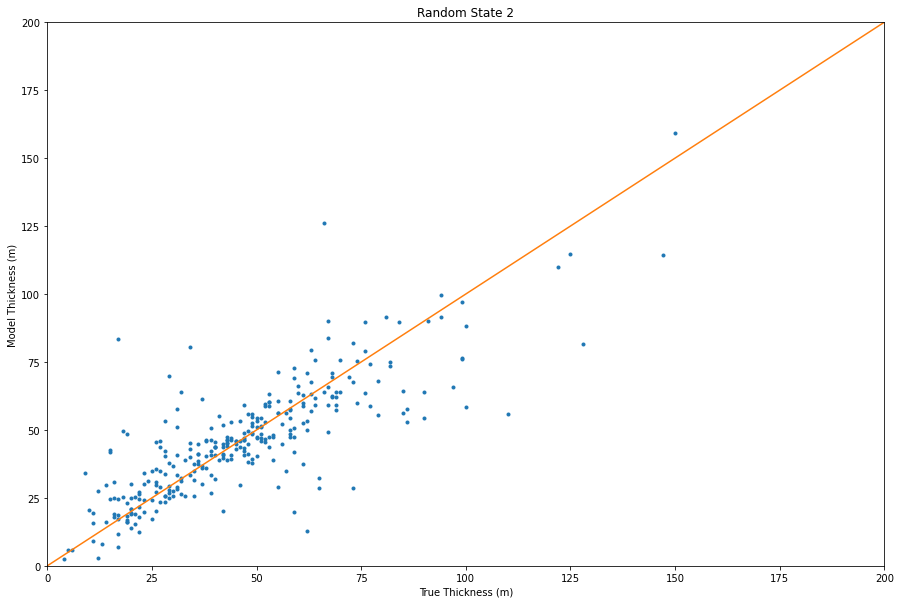

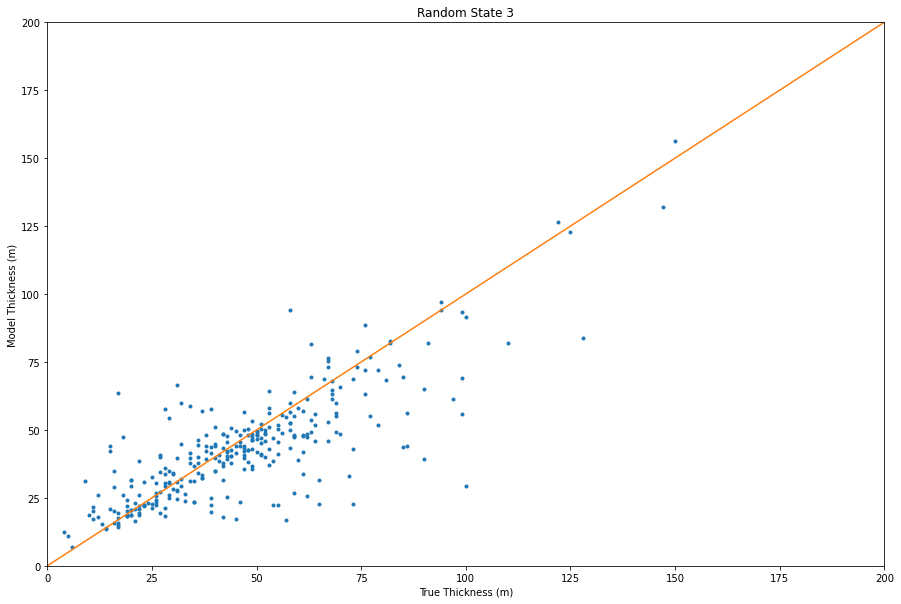

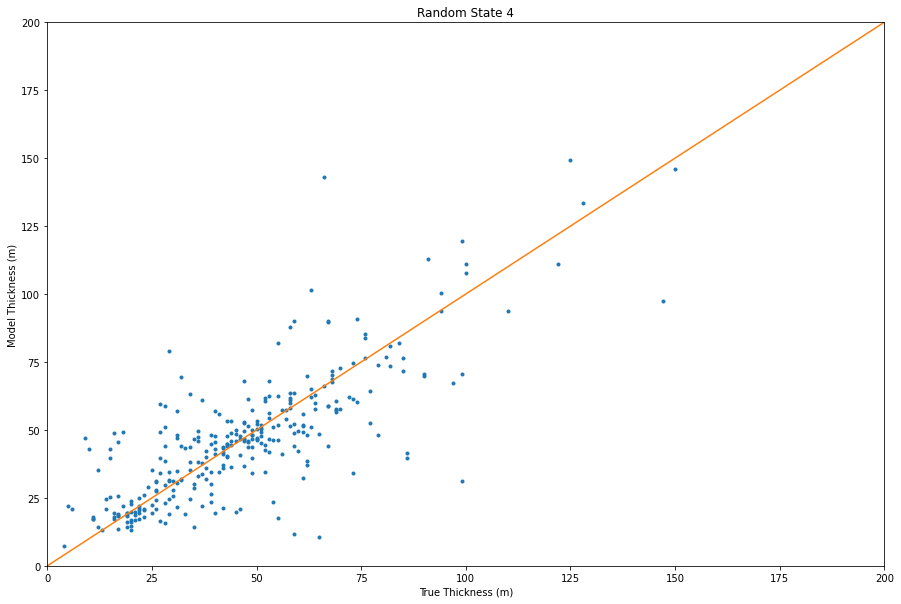

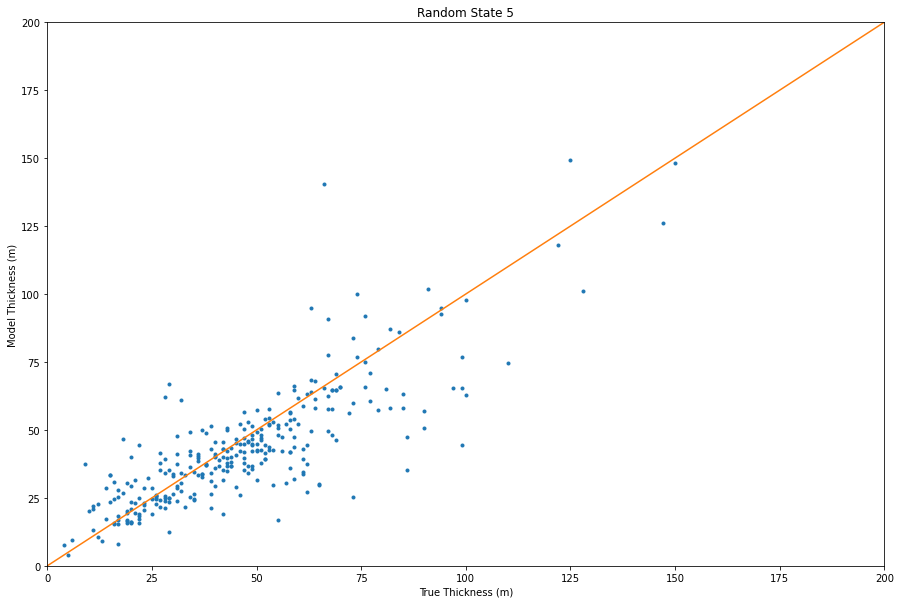

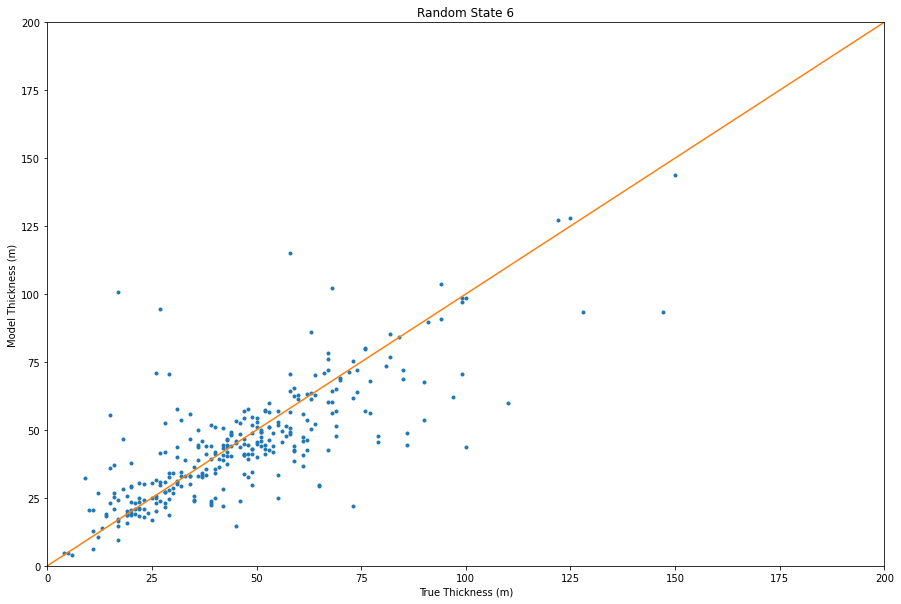

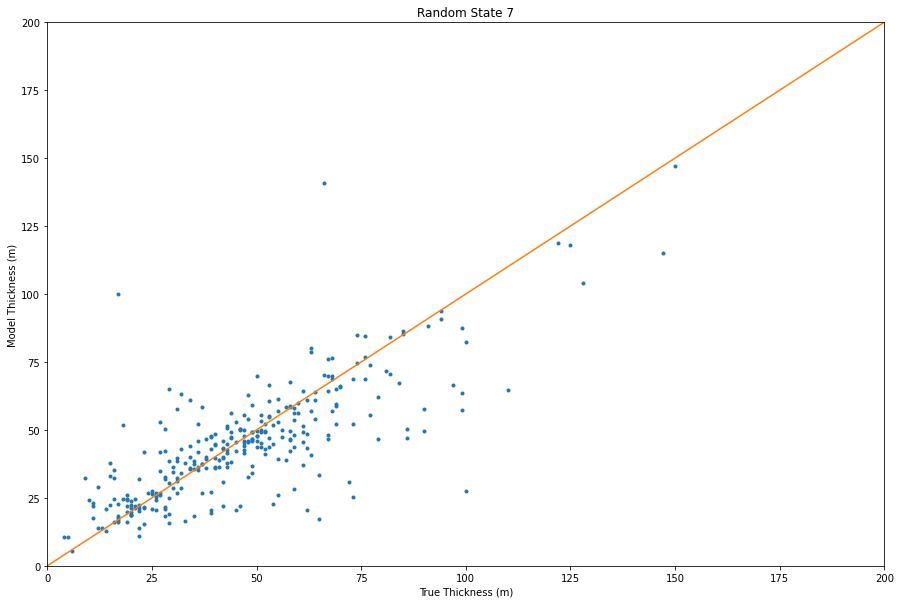

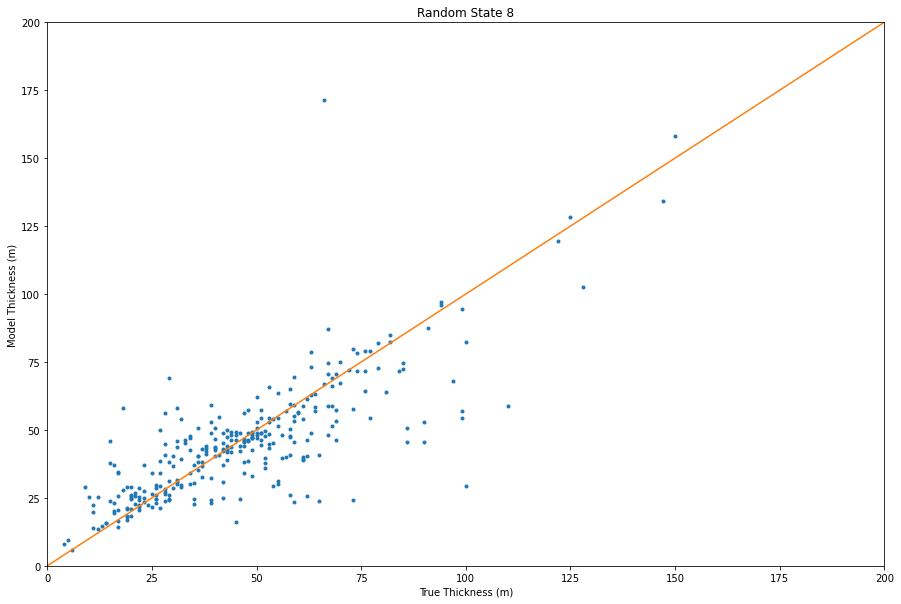

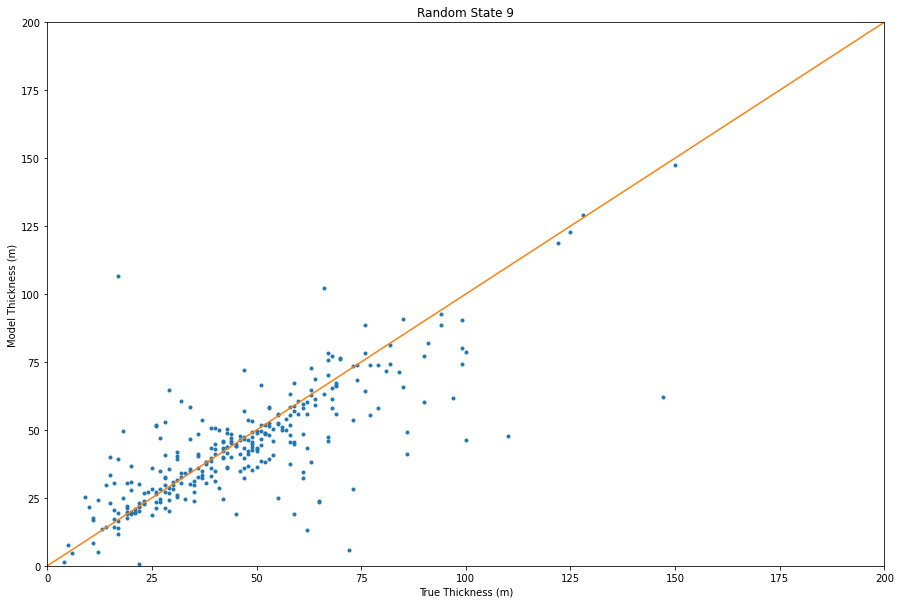

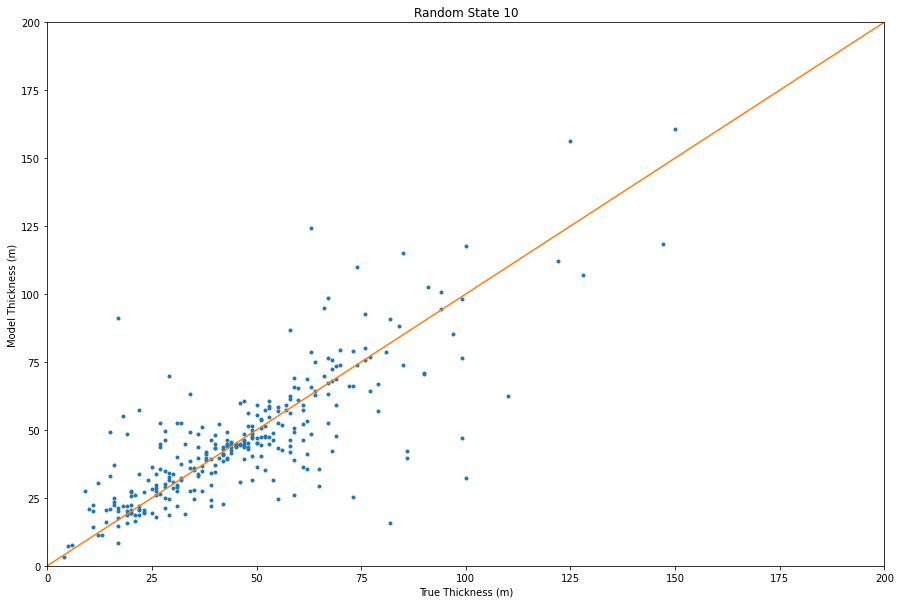

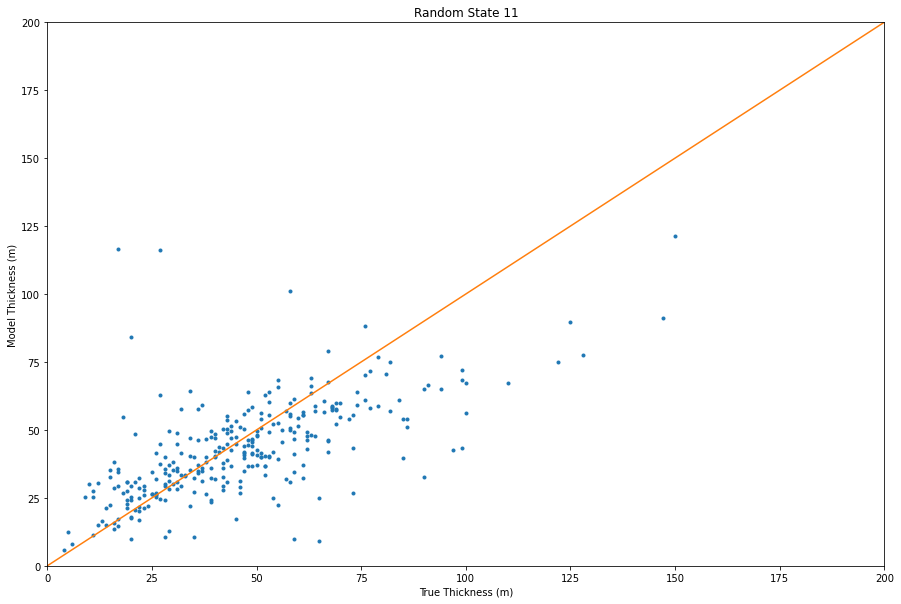

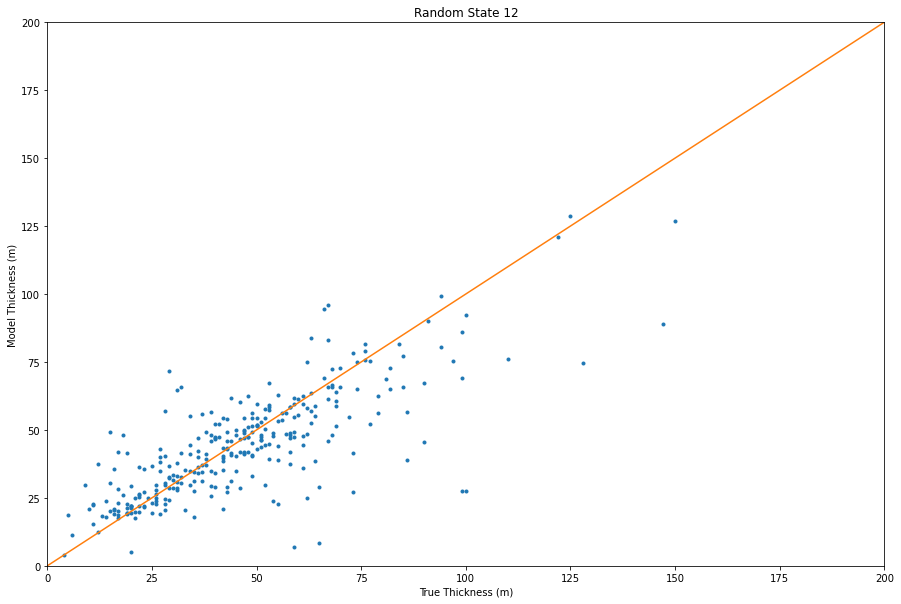

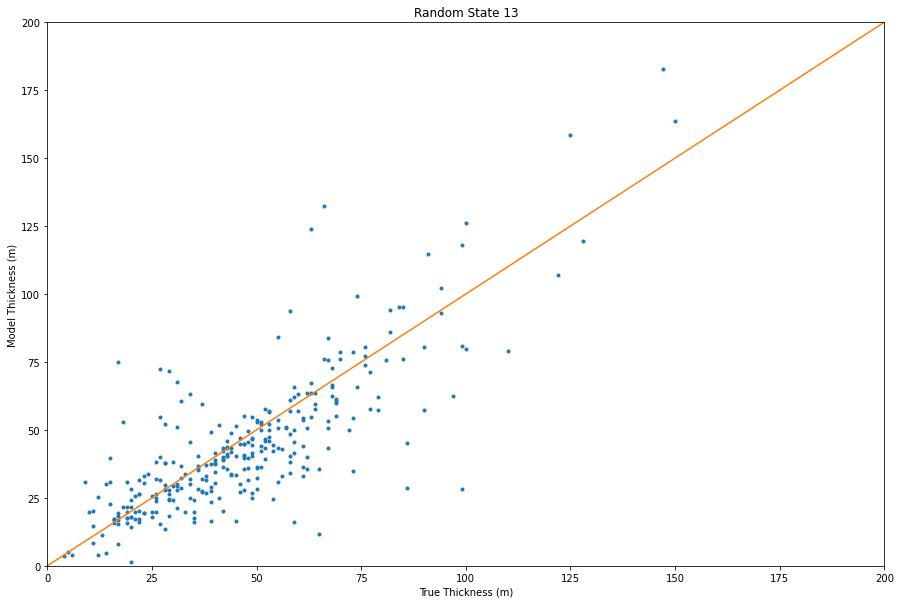

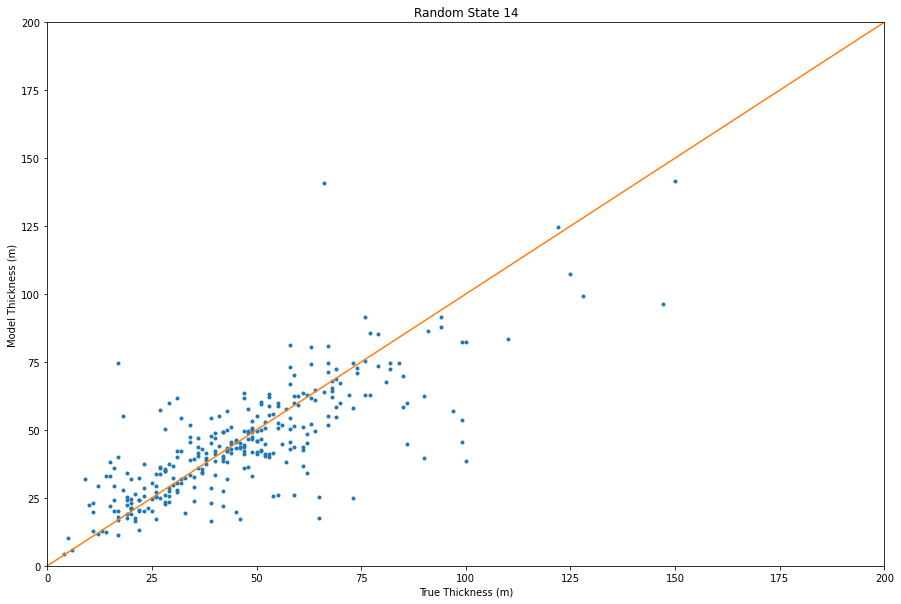

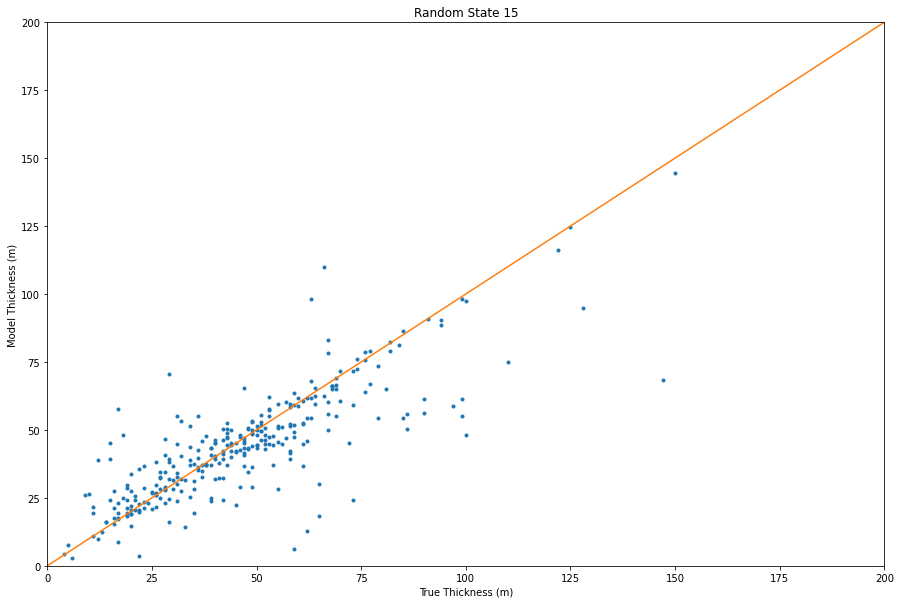

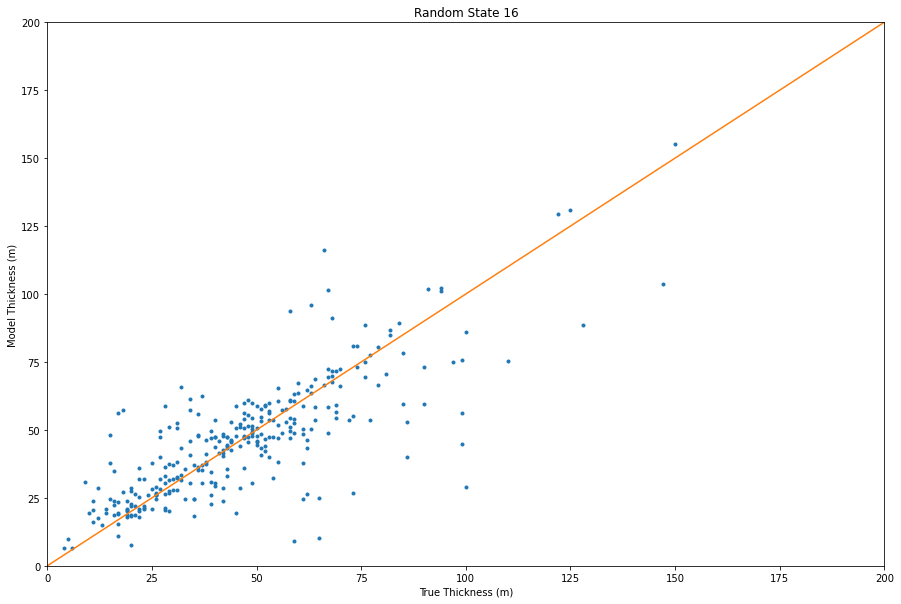

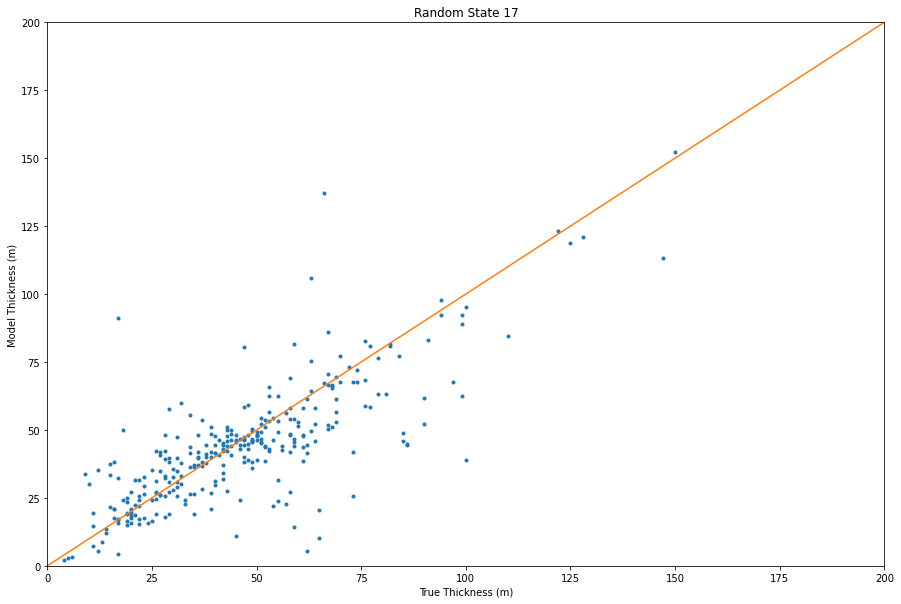

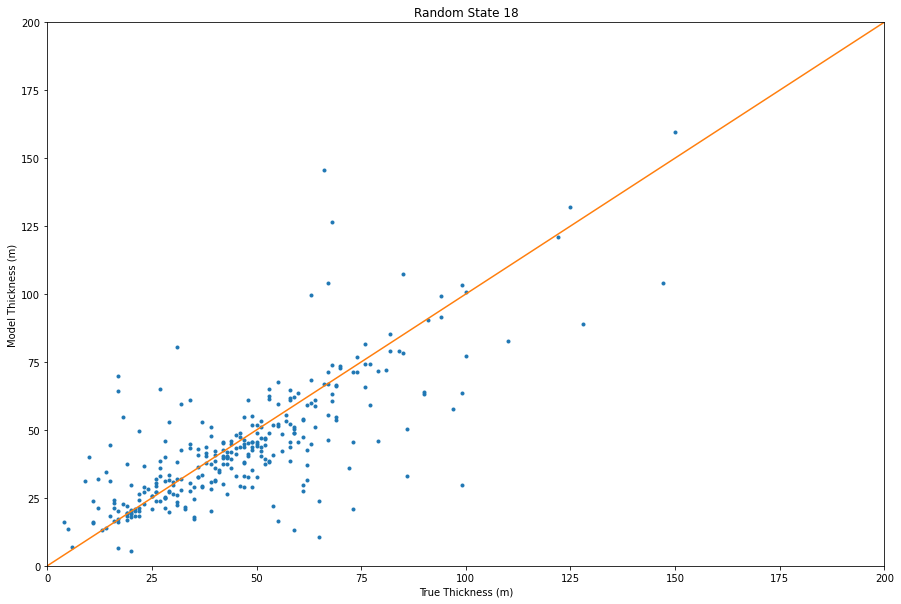

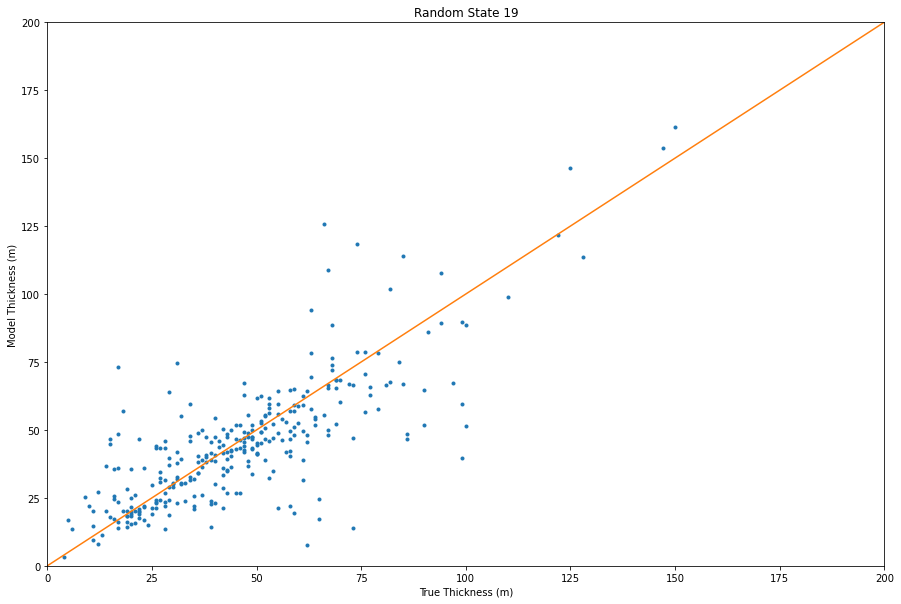

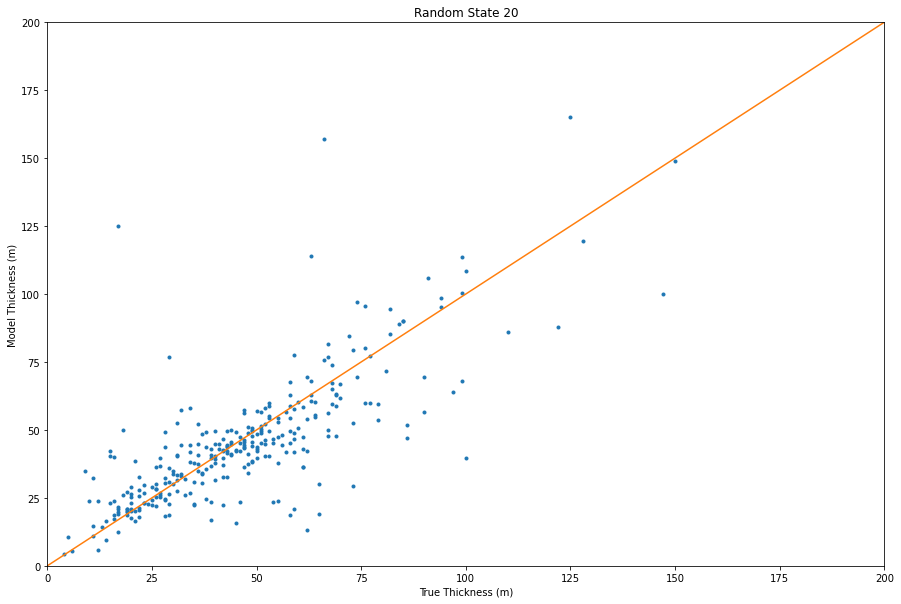

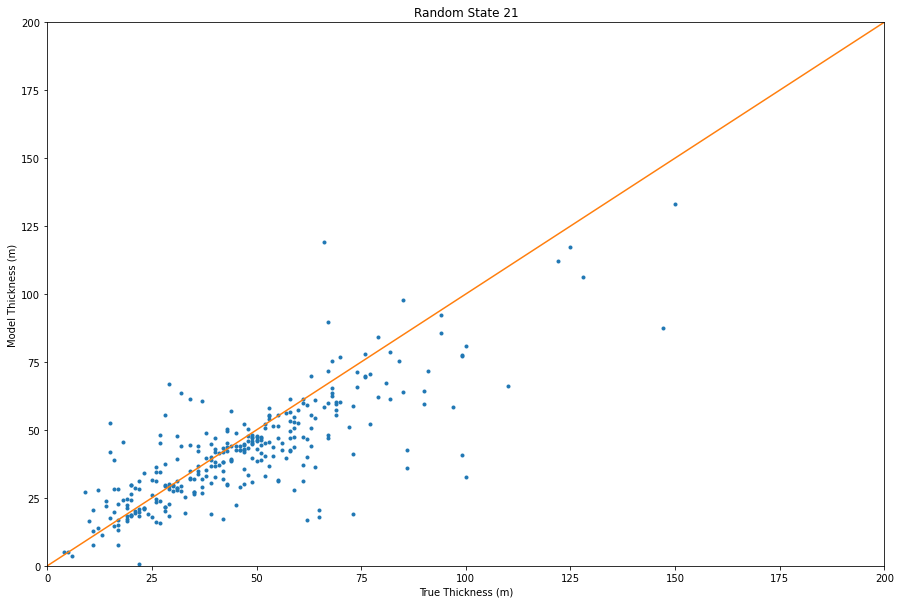

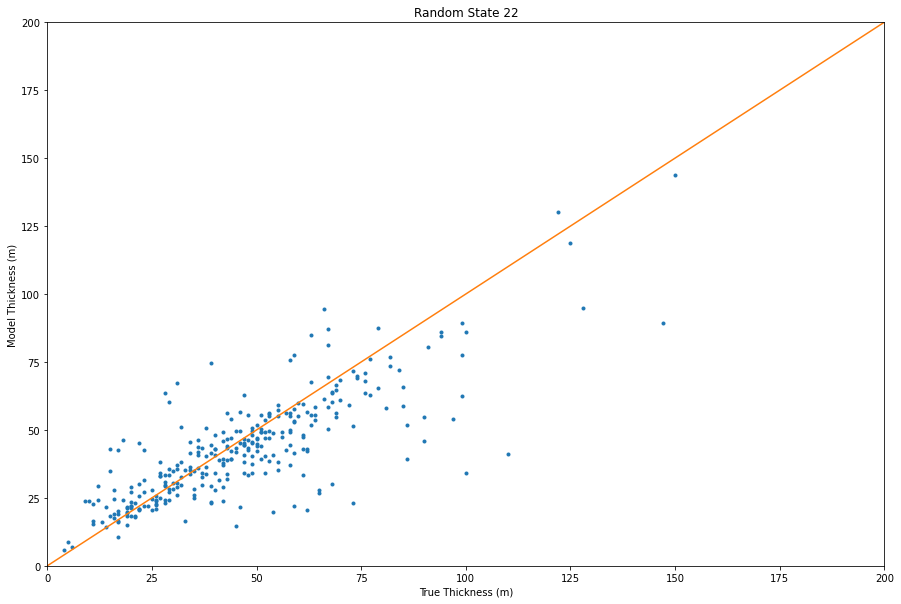

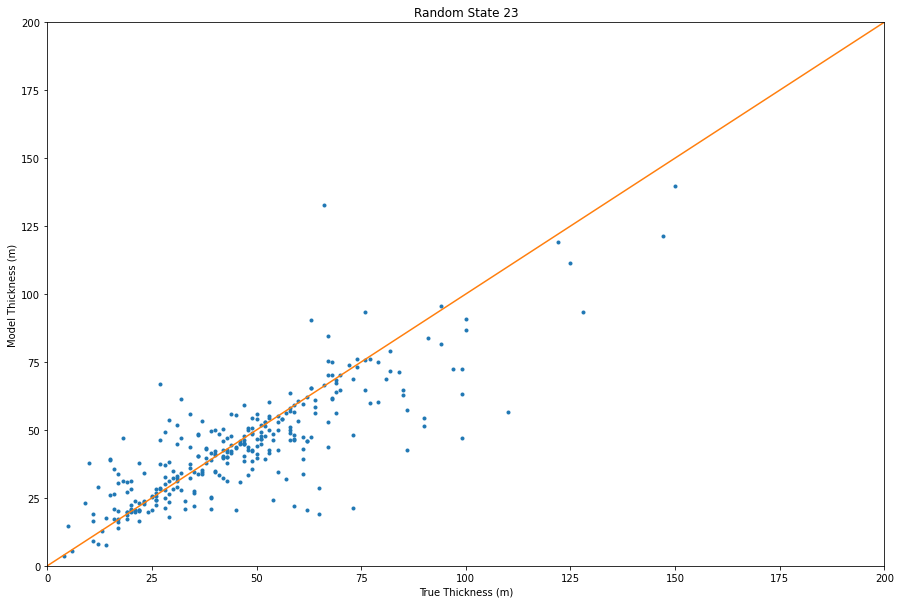

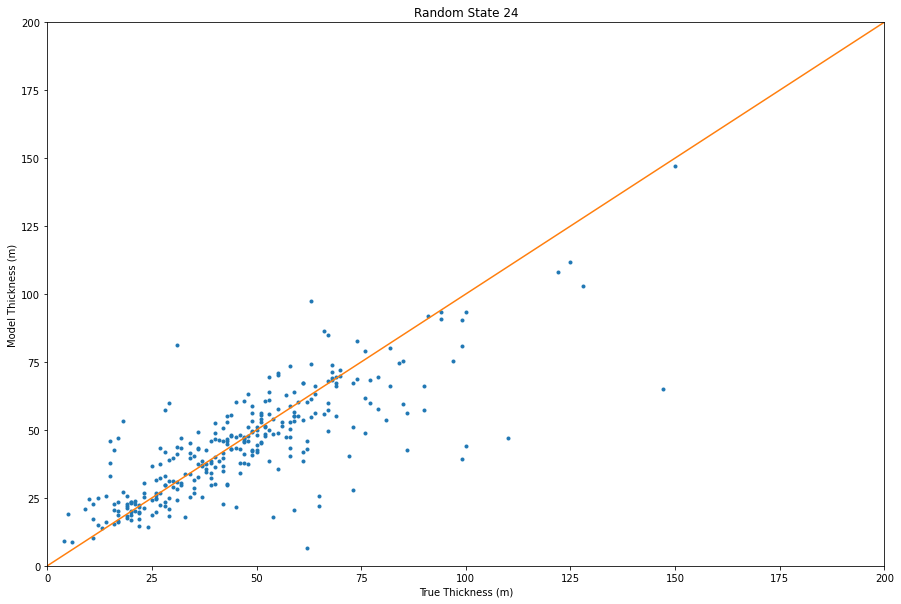

In [228]:
"""
Here we load top rated model and look at predicted accuracies of each random state
"""
arch = deviations_Glam['layer architecture'].loc[1]
top_learning_rate = deviations_Glam['learning rate'].loc[1]
dnn_model = {}
predictions = pd.DataFrame()
rootdir = 'saved_models/sm2/sm_' + arch + '/'
print('loading and evaluating models...')
for i in tqdm(os.listdir(rootdir)):
    if 'MULTI' in i and 'dnn' in i and str(top_learning_rate) in i:
        dnn_model[arch + '_' + i] = tf.keras.models.load_model(rootdir + i)

train_features, test_features, train_labels, test_labels = gl.data_splitter(Glam)
features = [train_features, test_features]
features = pd.concat(features)
labels = [train_labels, test_labels]
labels = pd.concat(labels)
for rs in RS:
    hhh = str(arch) + '_Glam_dnn_MULTI_' + str(top_learning_rate) + '_0.2_300_' + str(rs)
    y = dnn_model[hhh].predict(features, verbose = 0)
    fig,ax=plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('w')
    plt.plot(labels,y,'.')
    plt.plot((0,200),(0,200),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,200))
    plt.ylim((0,200))
    
#     y = pd.Series(y.flatten())
#     accuracy = y - labels

#     # step 1: calculate mean of numbers
#     accuracy_mean = sum(accuracy) / len(accuracy)


#     diff_sq = pd.Series()
#     # step 2: subtract the mean from each, then square the result
#     for i in accuracy:
#         step_2 = pd.Series((accuracy_mean - i)**2)
#         diff_sq = diff_sq.append(step_2, ignore_index = True)


#     # step 3: work out the mean of the squared differences 
#     mean_diff_sq = (np.sum(diff_sq) / len(diff_sq))
#     # step 4: take the square root
#     std_dev = np.sqrt(mean_diff_sq)
#     print(rs)
#     print(std_dev)

In [230]:
arch

'32-16-8'

In [ ]:
rootdir = 'saved_results/sr4/sr_' + arch + '/'
dnn_history = {}
for rs in RS: 
    dnn_history[
        arch + 
        '_Glam_phys_dnn_history_MULTI_0.01_0.2_300_' + 
        str(rs)
    ] = pd.read_csv(
        rootdir + 
        'Glam_phys_dnn_history_MULTI_0.01_0.2_300_' +
        str(rs)
    )
#     print(arch + '_Glam_dnn_history_MULTI_0.001_0.2_300_' + str(rs))

for hist in dnn_history:    
    fig,ax=plt.subplots(1,1,figsize=(10,10))
    fig.patch.set_facecolor('w')
    ax.set_title(hist)
    gl.plot_loss(dnn_history[hist])

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


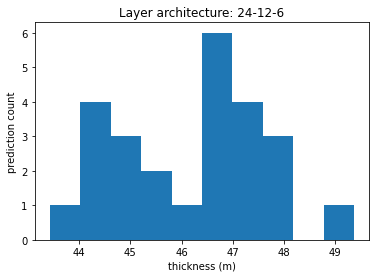

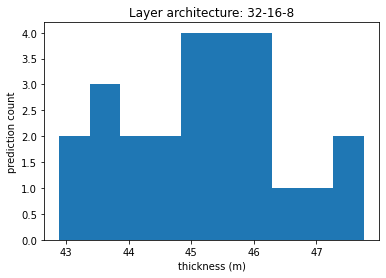

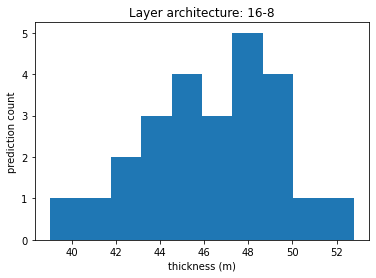

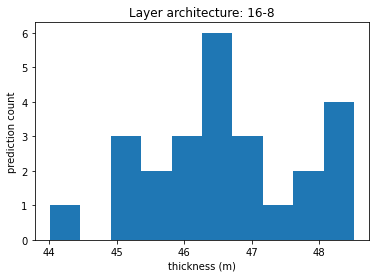

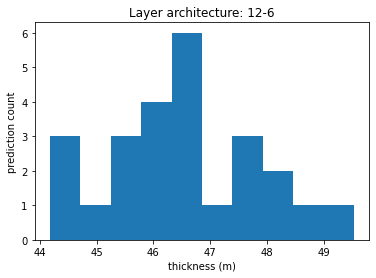

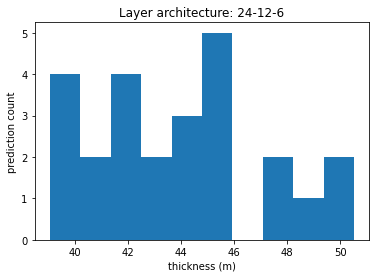

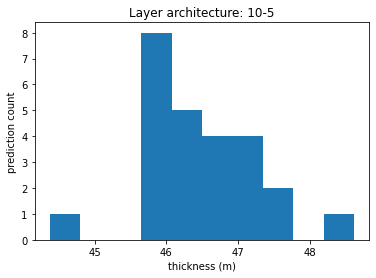

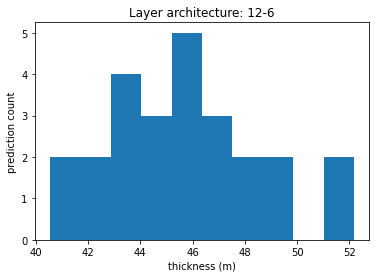

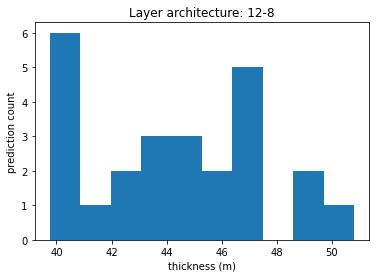

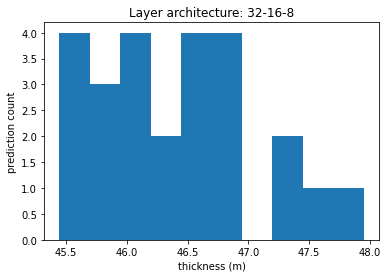

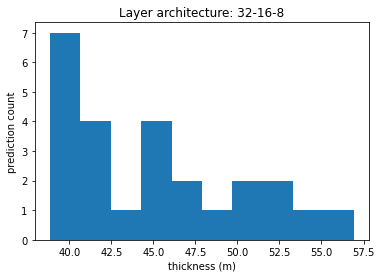

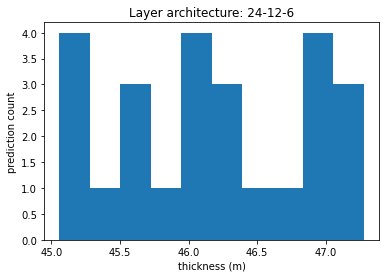

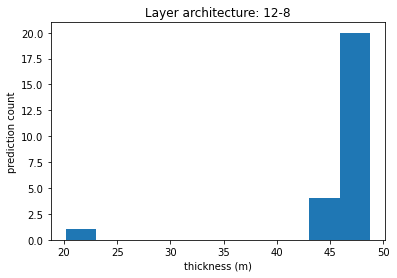

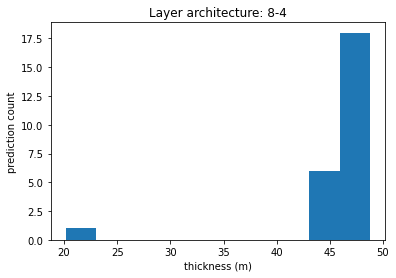

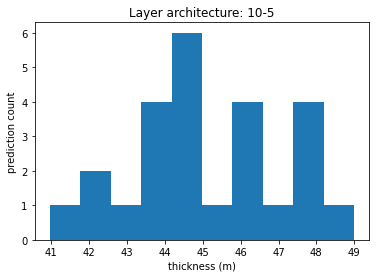

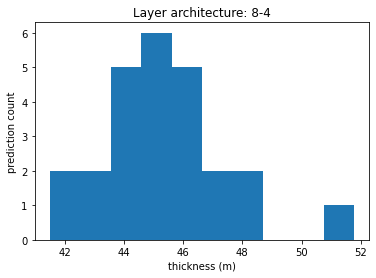

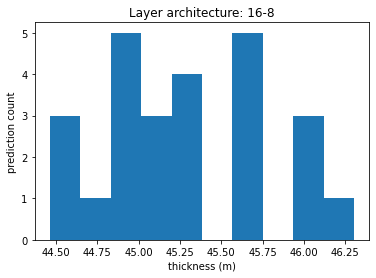

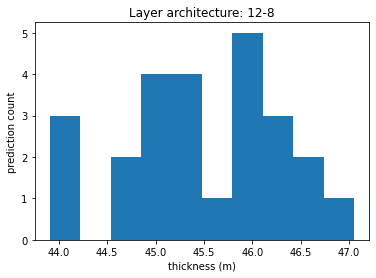

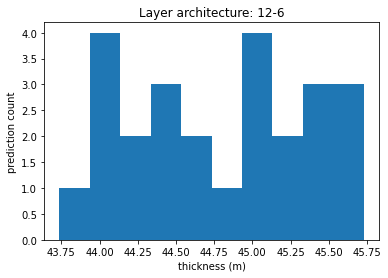

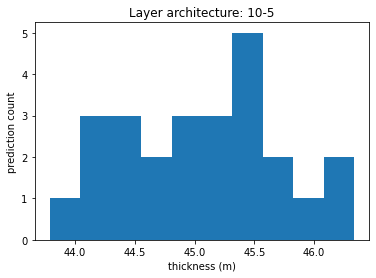

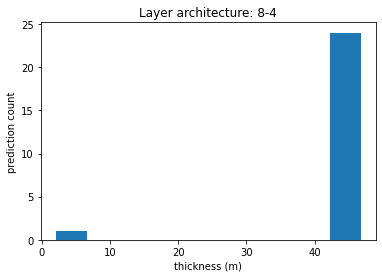

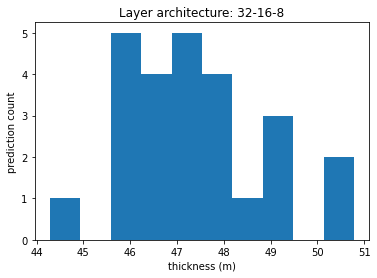

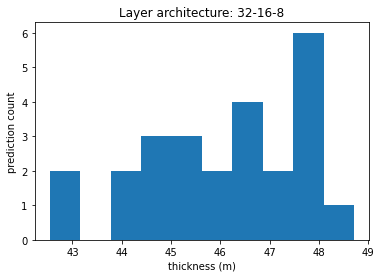

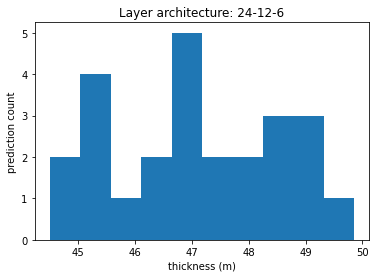

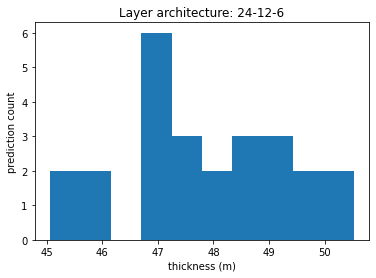

In [215]:
"""
This cell contains code to produce histograms of all the architectures different histories
"""

for i in deviations_Glam.index:
#     print(i)
    df = deviations_Glam.iloc[i]
    architecture = df['layer architecture']
    top_learn_rate = df['learning rate']
    epochs = df['epochs']

    dfs = predictions[
        (predictions['architecture'] == architecture) &
        (predictions['learning rate'] == top_learn_rate) &
        (predictions['epochs'] == epochs)
    ]
    fig,ax = plt.subplots()
    ax.set_title('Layer architecture: ' + architecture )
    ax.set_ylabel('prediction count')
    ax.set_xlabel('thickness (m)')
    fig.patch.set_facecolor('w')
    plt.hist(dfs['avg test thickness'])


In [8]:
ccccombo_breaker()
# past this point is under construction. 
# here be monsters

NameError: name 'ccccombo_breaker' is not defined

In [196]:
predictions = pd.read_csv('zults/predictions_Glam.csv')

In [202]:
predictions

,Unnamed: 0,avg train thickness,avg test thickness,model,test mae,train mae,architecture,validation split,learning rate,epochs
0,0,43.437372,44.152544,Glam_dnn_MULTI_0.001_0.2_300_0,15.113121,14.676870,10-5,0.2,0.001,300
1,1,43.974047,44.513756,Glam_dnn_MULTI_0.001_0.2_300_1,13.810594,14.552618,10-5,0.2,0.001,300
2,2,44.561065,44.737121,Glam_dnn_MULTI_0.001_0.2_300_10,14.165979,15.104191,10-5,0.2,0.001,300
3,3,44.774713,45.416400,Glam_dnn_MULTI_0.001_0.2_300_11,14.078907,14.581888,10-5,0.2,0.001,300
4,4,44.199821,44.438100,Glam_dnn_MULTI_0.001_0.2_300_12,14.295301,15.182826,10-5,0.2,0.001,300
...,...,...,...,...,...,...,...,...,...,...
620,620,45.760443,44.667464,Glam_dnn_MULTI_0.1_0.2_300_5,13.313203,10.803249,8-4,0.2,0.100,300
621,621,48.967969,46.151547,Glam_dnn_MULTI_0.1_0.2_300_6,12.820053,12.446630,8-4,0.2,0.100,300
622,622,43.894396,42.438068,Glam_dnn_MULTI_0.1_0.2_300_7,14.751464,10.568464,8-4,0.2,0.100,300
623,623,44.148956,45.061435,Glam_dnn_MULTI_0.1_0.2_300_8,12.616930,12.399732,8-4,0.2,0.100,300


In [203]:
dfs

,Unnamed: 0,avg train thickness,avg test thickness,model,test mae,train mae,architecture,validation split,learning rate,epochs
325,325,45.026507,44.365246,Glam_dnn_MULTI_0.01_0.2_300_0,10.224948,10.101419,24-12-6,0.2,0.01,300
326,326,48.115912,49.365278,Glam_dnn_MULTI_0.01_0.2_300_1,9.124382,11.508429,24-12-6,0.2,0.01,300
327,327,47.021237,44.648077,Glam_dnn_MULTI_0.01_0.2_300_10,9.582573,9.168507,24-12-6,0.2,0.01,300
328,328,44.219001,43.430540,Glam_dnn_MULTI_0.01_0.2_300_11,10.942597,10.503312,24-12-6,0.2,0.01,300
329,329,47.520153,47.016614,Glam_dnn_MULTI_0.01_0.2_300_12,10.509830,10.280487,24-12-6,0.2,0.01,300
330,330,47.702878,46.978091,Glam_dnn_MULTI_0.01_0.2_300_13,11.310276,10.040359,24-12-6,0.2,0.01,300
331,331,45.873246,46.462122,Glam_dnn_MULTI_0.01_0.2_300_14,9.995647,10.675703,24-12-6,0.2,0.01,300
332,332,46.824952,47.943592,Glam_dnn_MULTI_0.01_0.2_300_15,10.684124,11.684299,24-12-6,0.2,0.01,300
333,333,44.929173,45.672635,Glam_dnn_MULTI_0.01_0.2_300_16,11.633777,11.463470,24-12-6,0.2,0.01,300
334,334,44.490450,44.625536,Glam_dnn_MULTI_0.01_0.2_300_17,12.343226,10.884808,24-12-6,0.2,0.01,300


In [194]:
df

,layer architecture,model parameters,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev
0,24-12-6,644.0,0.01,0.2,300,10.680168,10.624562,0.86126,0.760157,1.358634,1.324749


In [157]:
rootdir = '/data/fast0/datasets/rgi60-attribs/'
RGI_extra = pd.DataFrame()
for file in tqdm(os.listdir(rootdir)):
    f = pd.read_csv(rootdir+file, encoding_errors = 'replace', on_bad_lines = 'skip')
    RGI_extra = RGI_extra.append(f, ignore_index = True)
    

RGI = RGI_extra[[
    'CenLat',
    'CenLon',
    'Slope',
    'Zmin',
    'Zmed',
    'Zmax',
    'Area',
    'Aspect',
    'Lmax'
]]

RGI

100%|██████████| 19/19 [00:00<00:00, 29.76it/s]


,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax
0,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839
1,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197
2,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106
3,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175
4,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981
...,...,...,...,...,...,...,...,...,...
216496,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255
216497,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130
216498,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329
216499,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106


In [166]:
RGI_rejects = pd.concat([
    RGI.loc[RGI.loc[RGI['Zmed']<0].index], 
    RGI.loc[RGI.loc[RGI['Lmax']<0].index], 
    RGI.loc[RGI.loc[RGI['Slope']<0].index],
    RGI.loc[RGI.loc[RGI['Aspect']<0].index]
])

RGI_rejects = RGI_rejects.drop_duplicates()
RGI_rejects

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax
50005,83.0904,-72.9017,0.0,-999,-999,-999,0.618,-9,25
50008,83.0207,-73.2693,0.0,-999,-999,-999,0.300,315,206
60523,71.5137,-51.7846,-9.0,-999,-999,-999,0.127,-9,-9
62053,60.5668,-43.0969,-9.0,-999,-999,-999,0.217,-9,-9
78754,64.1058,-17.0734,-9.0,-999,-999,-999,0.126,-9,-9
...,...,...,...,...,...,...,...,...,...
70156,67.1635,-33.4638,19.4,55,245,378,0.162,-9,504
70732,68.2244,-30.2741,37.2,716,853,932,0.095,-9,342
77901,74.3648,-21.0599,0.0,1110,1351,1514,1.885,-9,1049
77927,74.4006,-21.0963,21.2,1084,1277,1378,1.295,-9,913


In [167]:
sum(RGI_rejects['Slope']<0)

13

In [168]:
sum(RGI_rejects['Zmin']<0)

11

In [169]:
sum(RGI_rejects['Zmed']<0)

2779

In [170]:
sum(RGI_rejects['Zmax']<0)

17

In [171]:
sum(RGI_rejects['Area']<0)

0

In [172]:
sum(RGI_rejects['Aspect']<0)

673

In [173]:
sum(RGI_rejects['Lmax']<0)

5482

In [174]:
RGI = RGI.drop(RGI.loc[RGI['Zmed']<0].index)
RGI = RGI.drop(RGI.loc[RGI['Lmax']<0].index)
RGI = RGI.drop(RGI.loc[RGI['Slope']<0].index)
RGI = RGI.drop(RGI.loc[RGI['Aspect']<0].index)
RGI = RGI.reset_index()
RGI = RGI.drop('index', axis=1)

In [175]:
RGI_back = pd.concat([RGI, RGI_rejects])

In [176]:
RGI_back

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax
0,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839
1,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197
2,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106
3,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175
4,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981
...,...,...,...,...,...,...,...,...,...
70156,67.1635,-33.4638,19.4,55,245,378,0.162,-9,504
70732,68.2244,-30.2741,37.2,716,853,932,0.095,-9,342
77901,74.3648,-21.0599,0.0,1110,1351,1514,1.885,-9,1049
77927,74.4006,-21.0963,21.2,1084,1277,1378,1.295,-9,913


In [13]:
"""
This is a density plot of the most recent predictions made. Can easily be modified in a loop
to show multiple random states and whatnot
"""
sns.set(rc={"figure.figsize":(15,10)})
sns.kdeplot(x = test_labels, y = y.flatten(),fill = True)
plt.plot((0,300),(0,300),'-')

ValueError: array length 306 does not match index length 61

In [ ]:
# def plot_single_variable(x,y,model_type,model_name,feature_name):
#     y = model_type[model_name].predict(test_labels)
#     plt.scatter(train_features[feature_name], train_labels, label='Data')
#     plt.plot(x, y,'.', color='k', label='Predictions')
#     plt.xlabel(feature_name)
#     plt.ylabel('THICKNESS')
#     plt.legend()
#     plt.plot()

# x = test_labels
# for i, variable_name in enumerate(list(train_features)):
#     ax = plt.subplot(2,2,i+1)
#     model_name = (dataset.name 
#     + '_' 
#     + variable_name 
#     + '_' 
#     + str(lr) 
#     + '_' 
#     + str(vs) 
#     + '_' 
#     + str(ep))
#     plot_single_variable(x,y,dnn_model, model_name,variable_name)
# #     ax.set_ylim([35,140])
# #     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
# plt.tight_layout()

In [ ]:
"""
This cell computes the true average thickness of the glaciers in use
"""


pth = '/data/fast1/glacierml/T_models/'
T_lab = pd.read_csv(pth + 'T.csv', low_memory = False)
T_lab = T_lab[[
    'GlaThiDa_ID',
    'LAT',
    'LON',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS'
]]
T_lab = T_lab.dropna()

tru_thickness = np.sum(T_lab['MEAN_THICKNESS']) / len(T_lab['MEAN_THICKNESS'])
tru_thickness